<a href="https://colab.research.google.com/github/ionhedes/CA2020/blob/master/SW/MNIST_BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Installs

In [1]:
!pip install larq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install netron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00


## Settings & imports

In [3]:
#===== Reproducibility Settings (Before TensorFlow Import) =====#
import os
#*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

In [25]:
from sys import stdout
from math import frexp
import tensorflow as tf
import larq as lq
import numpy as np
import netron
from google.colab import output, drive
from typing import Dict, List
from json import dump, load
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
tf.random.set_seed(1)

## Storage and paths

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
workdir = './drive/MyDrive/'

# Debug

In [8]:
DEBUG = True

In [9]:
def _dbg(msg: str) -> None:
    if 'DEBUG' in globals() and DEBUG == True:
        print(msg)

# Dataset download

In [10]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape((60000, 28, 28, 1))
test_x = test_x.reshape((10000, 28, 28, 1))

# Center pixel values around 0. They will be quantized to -1, 1 by the network
train_x, test_x = train_x - 127.5, test_x - 127.5

11490434/11490434 [==============================] - 1s 0us/step


# Model architecture and instantiation

In [11]:
def create_lenet() -> tf.keras.Model:
    # All quantized layers use ste_sign for input and weights, and the weights are clipped between -1 and 1
    kwargs = dict(use_bias=False,
                input_quantizer="ste_sign",
                kernel_quantizer="ste_sign",
                kernel_constraint="weight_clip")

    model = tf.keras.models.Sequential()

    # 5x5 first layer much better (~95 to ~98) and slightly cheaper (2.7 to 2.6). 16 channel first layer much cheaper (1.1 to 0.6), and slightly worse (~98 to ~97), 8 channel is 0.6 to 0.3 and ~97 to ~94
    model.add(lq.layers.QuantConv2D(8, (5, 5), input_shape=(28, 28, 1), **kwargs))
    model.add(tf.keras.layers.MaxPooling2D((3, 3))) # With 5x5 kernel, 3x3 max pooling is only slightly lower than 2x2 (~98 to ~97), and much cheaper (2.6 to 1.1)
    model.add(tf.keras.layers.BatchNormalization(scale=False, center=False)) # center=False lowers accuracy from ~96 to ~95, LayerNorm seems better but also more complex

    # Given above 8, 64 -> 32 is 0.3 to 0.2 and -0.5
    model.add(lq.layers.QuantConv2D(32, (3, 3), **kwargs))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization(scale=False, center=False))

    # Optional layer for ~+0
    # model.add(lq.layers.QuantConv2D(64, (3, 3), **kwargs)) # A third conv layer is cheaper (2.7M MACs) and better (~95) than a 256 dense layer (2.8M MACs and ~94)
    # model.add(tf.keras.layers.BatchNormalization(scale=False, center=False))

    model.add(tf.keras.layers.Flatten())
    model.add(lq.layers.QuantDense(64, **kwargs))
    model.add(tf.keras.layers.BatchNormalization(scale=False, center=False))
    model.add(lq.layers.QuantDense(10, **kwargs))
    model.add(tf.keras.layers.BatchNormalization(scale=False,  center=False))
    #model.add(tf.keras.layers.Activation(lq.quantizers.SteSign()))
    model.add(tf.keras.layers.Activation("softmax"))

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [12]:
model = create_lenet()
lq.models.summary(model)

+sequential stats----------------------------------------------------------------------------+
| Layer                  Input prec.          Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                       x 1       x 1    (kB)             |
+--------------------------------------------------------------------------------------------+
| quant_conv2d                     1  (-1, 24, 24, 8)      200         0    0.02      115200 |
| max_pooling2d                    -    (-1, 8, 8, 8)        0         0       0           0 |
| batch_normalization              -    (-1, 8, 8, 8)        0        16    0.06           0 |
| quant_conv2d_1                   1   (-1, 6, 6, 32)     2304         0    0.28       82944 |
| max_pooling2d_1                  -   (-1, 3, 3, 32)        0         0       0           0 |
| batch_normalization_1            -   (-1, 3, 3, 32)        0        64    0.25           0 |
| flatten                          -        (-1, 2

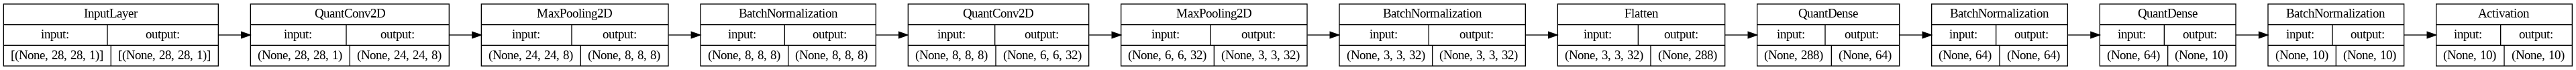

In [13]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True, show_layer_names=False)

# Training
***Do not run if you're importing the weights from a previous run!***

In [ ]:
model.fit(train_x, train_y, batch_size=64, epochs=10)
test_loss, test_acc = model.evaluate(test_x, test_y)
print(f"Test accuracy {test_acc * 100:.2f} %")

# Integer quantization of non-binary weights
***Don't run the weight import if you run this!***

**What is the objective?**
Get a Keras model with integer and binary weights only.

**What strategies have I thought of?**
1. naively truncate the weights of the current model
2. apply [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant) using TFLite

**Which strategy should we use?**

Naively truncating the weights to integers is easier and results in the same evaluation accuracy (in software). I haven't managed to make the 2nd method work yet. Therefore, I propose we use it (timestamp for future reference: **27.05, 3:59 PM**)

## Naively truncating the weights

**Steps:**
1. Copy the model without truncating the weights. Evaluate. *Why?* To make sure the same accuracy is achievable by naively copying weights from one model to another.
2. Copy the model and truncate the weights. Evaluate.
3. Copy the model (with `larq`'s `quantized_scope` set to `True`) and truncate the rest of the weights. Evaluate. *Why isn't step 2 enough?* Copying weights might not preserve `larq` quantization. The `larq` execution model is still unclear to me.

**Conclusion:**
- copying weights from one model to another is fine in general.
- truncating weights without ensuring `larq`'s quantization scope destroys performance.
- truncating weights while ensuring `larq`'s quantization scope preserves performance. <font color="lightgreen">We can use this strategy to obtain integer weights!</font>

In [ ]:
# copy & evaluate without truncation
copy_model = create_lenet()
for copy_layer, layer in zip(copy_model.layers, model.layers):
    copy_layer.set_weights(layer.get_weights())

copy_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
copy_model.evaluate(test_x, test_y)

In [ ]:
# copy & evaluate with truncation
int_model = create_lenet()
for int_layer, layer in zip(int_model.layers, model.layers):
    trunc_weights = [np.trunc(v) for v in layer.get_weights()]
    int_layer.set_weights(trunc_weights)

int_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
int_model.evaluate(test_x, test_y)

In [ ]:
# copy & evaluate with truncation & larq quantized scope
lq_int_model = create_lenet()
with lq.context.quantized_scope(True):
    for lq_int_layer, layer in zip(lq_int_model.layers, model.layers):
        trunc_weights = [np.ceil(v) for v in layer.get_weights()]  # better perf than .trunc
        lq_int_layer.set_weights(trunc_weights)

lq_int_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
lq_int_model.evaluate(test_x, test_y)

## ~Applying post-training quantization using TFLite~

**Steps:**
1. train model normally (see previous section)
2. quantize to integer weights using TFLite
3. inspect and evaluate TFLite model
4. extract the model weights and move them to a new Keras model (this step might be necessary to check if TFLite introduces bullshit optimizations)
5. evaluate the new Keras model. Are all the weights integers? Is the accuracy comparable to that of the initial model?

**Why not just use the TFLite model?**
Because it might include additional implicit optimizations that we're not aware of/can't easily reproduce in hardware.

**Conclusion:**
- TFLite introduces additional quantization operations that might be hard to replicate in hardware.
- Stopped at step 4. Until proven inappropriate, the **naive weight integer truncation** method is easier, and the go-to.

### Quantize

See [this](https://www.tensorflow.org/lite/performance/post_training_quantization), and [this](https://www.tensorflow.org/lite/performance/post_training_integer_quant) for possible integer quantization strategies.

Trying to apply **full-integer quantization** (all intermediate operations use integers, no falling back to float operations) to best simulate the hardware environment we're building

See [this](https://www.tensorflow.org/lite/guide/signatures) to learn what **signatures** are (used for creating representative datasets). A good explanation on why they're needed in this context can be found [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant#convert_using_float_fallback_quantization).

In [ ]:
REPR_DATASET_SIZE = 100

def representative_data_gen():
    # note: tensor-flavored generators are not encouraged, but I think they're
    # enough for our needs
    for inp in tf.data.Dataset.from_tensor_slices(train_x).batch(1).take(REPR_DATASET_SIZE):
        yield [np.float32(inp)]

In [ ]:
# set up converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# convert to tflite unquantized
tflite_model = converter.convert()

# convert to tflite quantized
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # signed 8-bit integer
converter.inference_output_type = tf.int8  # signed 8-bit integer
tflite_int_quant_model = converter.convert()

In [ ]:
# save quantized model
tflite_int_quant_model_name = 'tflite_int_quant_model'
with open(f'{workdir}/{tflite_int_quant_model_name}.tflite', 'wb') as fp:
    fp.write(tflite_int_quant_model)

# save non-quantized model as well
tflite_model_name = 'tflite_std_model'
with open(f'{workdir}/{tflite_model_name}.tflite', 'wb') as fp:
    fp.write(tflite_model)

### Inspect

**27.05 12:40 PM**
- `larq` might not be playing nicely with tflite (see Netron below) -- weights set to $\pm127$
- the `tflite` quantization seems to be introducing some bullshit in the model; do we need to move that to hardware?

In [ ]:
# inspect using prints (not really useful)
interpreter = tf.lite.Interpreter(model_content=tflite_int_quant_model)
tensor_details = interpreter.get_tensor_details()
for layer_dict in tensor_details:
    print(layer_dict)

In [ ]:
# visualize the quantized model using Netron
with output.temporary():
    host, port = netron.start(f'{workdir}/{tflite_int_quant_model_name}.tflite')

output.serve_kernel_port_as_iframe(port, height='800')

### Evaluate

**27.05 13:09 PM**
- `accuracy_tf_std == accuracy_tfl_std`
- `abs(accuracy_tf_std - accuracy_tfl_int_quant) == 0.12%`
- not sure if the tested models preserve the `larq` quantization

#### Helper functions
Copy-pasted and adjusted from [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant#run_the_tensorflow_lite_models)

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_model, test_images):
    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_images),), dtype=int)
    for i, test_image in enumerate(test_images):

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_model, test_images, test_labels, model_type):
    predictions = run_tflite_model(tflite_model, test_images)

    accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
          model_type, accuracy, len(test_images)))

#### Actual evaluation

In [ ]:
# evaluate integer quantized model (tflite version)
evaluate_model(tflite_int_quant_model, test_x, test_y, model_type='Quantized')

In [ ]:
# evaluate non-quantized model (tflite version)
evaluate_model(tflite_model, test_x, test_y, model_type='Float')

### Create new Keras model

In [ ]:
# stopped here because I succeeded obtaining an integer-weighted model
# using the other method

# Weight import
***Don't run the weight export and weight quantization steps if you run this!***

## Weight import script and execution

In [14]:
def _import_dense_weights(layer,
                           weights: List) -> Dict:

    if len(weights.keys()) == 2:
        # with biases
        # make sure this is indeed the correct order
        _dbg(f"\t\t - weights\n"
             f"\t\t - biases")
    elif len(weights.keys()) == 1:
        # without biases
        _dbg(f"\t\t - weights")
    else:
        raise ValueError('Too many weight tensors in this layer.')

    weights_list = [np.array(arr) for arr in weights.values()]
    layer.set_weights(weights_list)

In [15]:
def _import_bn_weights(layer,
                        weights: List) -> Dict:

    if len(weights.keys()) == 2:
        # no betas, gammas
        # make sure this is indeed the correct order
        _dbg(f"\t\t - means\n"
             f"\t\t - variances")
    elif len(weights.keys()) == 4:
        # with betas, gammas
        _dbg(f"\t\t - means\n"
             f"\t\t - variances\n"
             f"\t\t - betas\n"
             f"\t\t - gammas")
        raise NotImplementedError('Importing weights is not implemented for batch normalization with scaling and centering.')
    else:
        raise ValueError('Too many weight tensors in this layer.')


    weights_list = [np.array(arr) for arr in weights.values()]
    layer.set_weights(weights_list)

In [16]:
def _import_conv_weights(layer,
                          weights: Dict) -> None:

    if len(weights.keys()) == 2:
        # with biases
        # make sure this is indeed the correct order
        _dbg(f"\t\t - kernels\n"
             f"\t\t - biases")
    elif len(weights.keys()) == 1:
        # without biases
        _dbg(f"\t\t - kernels")
    else:
        raise ValueError('Too many weight tensors in this layer.')

    weights_list = [np.array(arr) for arr in weights.values()]
    layer.set_weights(weights_list)

In [17]:
def _dispatch_import_weights_layer_specific(layer,
                                            weights: Dict) -> None:
    weightless_layers = ['pool', 'flatten', 'activation']

    layer_name = layer.get_config()['name']

    if 'conv2d' in layer_name:
        _dbg(f"\t - convolutional layer <{layer_name}>")
        _import_conv_weights(layer, weights)
    elif 'batch_normalization' in layer_name:
        _dbg(f"\t - batch normalization layer <{layer_name}>")
        _import_bn_weights(layer, weights)
    elif 'dense' in layer_name:
        _dbg(f"\t - dense layer <{layer_name}>")
        _import_dense_weights(layer, weights)
    elif any([wl in layer_name for wl in weightless_layers]):
        # a supported layer that has no weights
        _dbg(f"\t - ignoring weightless layer <{layer_name}>")
        return dict()
    else:
        raise ValueError('This layer type is not supported.')

In [18]:
def import_weights(model: tf.keras.Model,
                    file_path: str,
                    file_name: str) -> None:
    """Imports the weights to the model. Make sure the neural network topology
    is the same.

    Args:
    `model` -- neural net model
    `quantized` -- set to true if you want to export `larq`-quantized weights
    `file_path` -- path to weight file.
    `file_name` -- name of the weight file.
    """

    _dbg(f"Importing weights from {file_path}/{file_name}.json")

    ret = dict()
    name_idx_dict = dict()

    with open(f'{file_path}{file_name}.json', 'r') as fp:

        # load json dict
        weights = load(fp)

        # iterate through layers
        for l, w in zip(model.layers, weights.values()):
            _dispatch_import_weights_layer_specific(l, w)

    _dbg("Weight import complete.")

In [19]:
weights_file_path = workdir
weights_file = 'weights_test'

In [20]:
model = create_lenet()
import_weights(model, file_path=weights_file_path, file_name=weights_file)

Importing weights from ./drive/MyDrive//weights_test.json
	 - convolutional layer <quant_conv2d_2>
		 - kernels
	 - ignoring weightless layer <max_pooling2d_2>
	 - batch normalization layer <batch_normalization_4>
		 - means
		 - variances
	 - convolutional layer <quant_conv2d_3>
		 - kernels
	 - ignoring weightless layer <max_pooling2d_3>
	 - batch normalization layer <batch_normalization_5>
		 - means
		 - variances
	 - ignoring weightless layer <flatten_1>
	 - dense layer <quant_dense_2>
		 - weights
	 - batch normalization layer <batch_normalization_6>
		 - means
		 - variances
	 - dense layer <quant_dense_3>
		 - weights
	 - batch normalization layer <batch_normalization_7>
		 - means
		 - variances
	 - ignoring weightless layer <activation_1>
Weight import complete.


## Weight import test
Evaluate the accuracy

In [21]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print(f"Test accuracy {test_acc * 100:.2f} %")

313/313 [==============================] - 2s 5ms/step - loss: 0.5347 - accuracy: 0.9439
Test accuracy 94.39 %


# Intermediate layer output inspection

## Utility functions for printing the intermediate layer output

In [321]:
def _adjust_layer_names(raw_names: List[str]) -> List[str]:
    """Removes the trailing dynamic index from the layer names,
    and appends a static index, relative to the provided list of names.

    Args:
    - `raw_names` -- the list of layer names

    Returns:
    `List[str]` -- a list containing the adjusted names for each layer
    """

    name_idx_dict = dict()  # keeps track of static layer indices
    adjusted_names = list()  # list to be returned

    # strip the initial dynamic indices
    last_underscore_idx = [rn.rfind('_') for rn in raw_names]
    names_no_idx = [rn[:lui] for (rn, lui) in zip(raw_names, last_underscore_idx)]

    # add the static indices
    for name in names_no_idx:
        if name not in name_idx_dict:
            name_idx_dict[name] = 1
        else:
            name_idx_dict[name] += 1
        name = f'{name}_{name_idx_dict[name]}'
        adjusted_names.append(name)

    return adjusted_names

In [322]:
def _unpack_batched_results(batched_res: List[np.ndarray]) -> List[np.ndarray]:
    """Squeezes the first dimension of the intermediate results.
    Works on the assumptions that a) Keras layers always generate
    batch outputs, and b) the batch dimension is always the first

    Args:
    `batched_res` -- a `List[np.ndarray]` of arrays with shape `(batch_size, x, y, z, ...)

    Returns:
    `List[np.ndarray]` of arrays with shape `(x, y, z, ...)`

    """

    return [res[0] for res in batched_res]

In [323]:
def _print_channel_intermediate_results_with_channels(fp,
                                                      ch_idx: int,
                                                      ch: np.ndarray) -> None:

    fp.write(f"\t CHANNEL {ch_idx}\n"
             f"\t\t [\n")

    for row in ch:
        fp.write(f"\t\t\t [{', '.join([f'{el:8.4f}' for el in row])}],\n")

    fp.write(f"\t\t ]\n")


def _print_intermediate_results_with_channels(fp,
                                              results: np.ndarray) -> None:

    # transpose dimensions (assumming the channel dim is the last)
    results = results.transpose(2, 0, 1)

    # iterate through channels
    for ch_idx, ch in enumerate(results):
        _print_channel_intermediate_results_with_channels(fp, ch_idx, ch)


def _print_intermediate_results_without_channels(fp,
                                                 results: np.ndarray,
                                                 max_row_width: int = 10) -> None:

    fp.write(f"\t [")

    for idx, el in enumerate(results):
        el = f"{el:8.4f},"
        fp.write(f"\n\t\t{el}" if idx % max_row_width == 0 else f"{el}")
                #  f" {el:8.4f},")

    fp.write("\n\t ]\n")

In [324]:
def _print_conv_intermediate_results(fp,
                                     layer_name: str,
                                     results: np.ndarray) -> None:

    # print the results
    _print_intermediate_results_with_channels(fp, results)

In [325]:
def _print_dense_intermediate_results(fp,
                                      layer_name: str,
                                      results: np.ndarray,
                                      max_row_width = 10) -> None:

    # print the results
    _print_intermediate_results_without_channels(fp, results)

In [326]:
def _print_bn_intermediate_results(fp,
                                   layer_name: str,
                                   results: np.ndarray) -> None:

    # check
    if results.ndim == 3:
        # bn after conv:
        _print_intermediate_results_with_channels(fp, results)
    elif results.ndim == 1:
        # bn after dense:
        _print_intermediate_results_without_channels(fp, results)
    else:
        raise ValueError(f"The result of batch normalization layer <{layer_name}> has an invalid shape.")

In [327]:
def _print_pool_intermediate_results(fp,
                                     layer_name: str,
                                     results: np.ndarray) -> None:

    # print the results
    _print_intermediate_results_with_channels(fp, results)

In [328]:
def _print_activation_intermediate_results(fp,
                                           layer_name: str,
                                           results: np.ndarray) -> None:

    # check
    if results.ndim == 3:
        # activation after conv:
        _print_intermediate_results_with_channels(fp, results)
    elif results.ndim == 1:
        # activation after dense:
        _print_intermediate_results_without_channels(fp, results)
    else:
        raise ValueError(f"The result of activation layer <{layer_name}> has an invalid shape.")

In [329]:
def _dispatch_print_intermediate_results_layer_specific(fp,
                                                        layer_name: str,
                                                        results: np.ndarray) -> None:

    ignored_layers = ['flatten']

    if 'conv2d' in layer_name:
        _dbg(f"\t - convolutional layer <{layer_name}>")
        _print_conv_intermediate_results(fp, layer_name, results)
    elif 'batch_normalization' in layer_name:
        _dbg(f"\t - batch normalization layer <{layer_name}>")
        _print_bn_intermediate_results(fp, layer_name, results)
    elif 'dense' in layer_name:
        _dbg(f"\t - dense layer <{layer_name}>")
        _print_dense_intermediate_results(fp, layer_name, results)
    elif 'pool' in layer_name:
        _dbg(f"\t - pooling layer <{layer_name}>")
        _print_pool_intermediate_results(fp, layer_name, results)
    elif 'activation' in layer_name:
        _dbg(f"\t - activation_layer <{layer_name}>")
        _print_activation_intermediate_results(fp, layer_name, results)
    elif any([l in layer_name for l in ignored_layers]):
        # a supported layer that has no outputs
        _dbg(f"\t - ignoring layer <{layer_name}>")
    else:
        raise ValueError('This layer type is not supported.')

In [330]:
def _return_dump_file_stream(path: str = None, file: str = None):

    if path is None or file is None:
        return stdout
    else:
        return open(f"{path}/{file}.txt", 'w')

## Utility functions for computing and adjusting intermediate layer output

In [331]:
def _compute_intermediate_layer_results(model: tf.keras.Model,
                                        inp: np.ndarray):

    # create the extractor model, which will provide the intermediate outputs
    extractor_inputs = model.inputs
    extractor_outputs = [layer.output for layer in model.layers]

    result_extractor = tf.keras.Model(
        inputs=extractor_inputs,
        outputs=extractor_outputs
    )

    # compute the results
    batched_results = result_extractor(inp[None, :])  # input dimension expansion (batching)
    results = _unpack_batched_results(batched_results)

    return results

In [332]:
def _uncompensate_conv_out(weights: List[np.ndarray], results: np.ndarray) -> np.ndarray:

    kernels = weights[0].transpose(3, 2, 0, 1)  # change to (cout x cin x h x w)
    kernel_size = kernels[0].size
    uncompensated_res = np.ceil((results + kernel_size) / 2)
    return uncompensated_res

In [346]:
def _uncompensate_dense_out(weights: List[np.ndarray], results: np.ndarray) -> np.ndarray:

    kernels = weights[0]
    kernel_size = kernels.shape[0]
    uncompensated_res = np.ceil((results + kernel_size) / 2)
    return uncompensated_res

In [334]:
def _simplify_bn_out(results: np.ndarray) -> np.ndarray:

    simplified_res = np.empty_like(results, dtype=np.int8)
    simplified_res = 1 - (results < 0)
    return simplified_res

In [335]:
def _dispatch_adjust_intermediate_results_layer_specific(layer_name: str,
                                                         results: np.ndarray,
                                                         weights: List[np.ndarray],
                                                         **kwargs) -> np.ndarray:

    # kwargs parse
    uncompensate_conv = kwargs['uncompensate_conv']
    uncompensate_dense = kwargs['uncompensate_dense']
    use_simplified_bn = kwargs['use_simplified_bn']

    # actual op
    ignored_layers = ['activation', 'pool', 'flatten']

    if 'conv2d' in layer_name:
        if uncompensate_conv:
            _dbg(f"\t\t - uncompensating output for convolutional layer <{layer_name}>")
            results = _uncompensate_conv_out(weights, results)
    elif 'dense' in layer_name:
        if uncompensate_dense:
            _dbg(f"\t\t - uncompensating output for dense layer <{layer_name}>")
            results = _uncompensate_dense_out(weights, results)
    elif 'batch_normalization' in layer_name:
        if use_simplified_bn:
            _dbg(f"\t\t - using simplified ops batch normalization layer <{layer_name}>")
            results = _simplify_bn_out(results)
    elif any([l in layer_name for l in ignored_layers]):
        # a supported layer that has no available adjustments
        results = results
    else:
        raise ValueError('This layer type is not supported.')

    return results

In [336]:
def _generate_simplify_bn_flags(layer_names: List[str],
                                use_simplified_bn: bool | str = False) -> np.ndarray:

    batch_norm_idx = ['batch_normalization' in name for name in layer_names]

    if use_simplified_bn is False:
        return np.zeros_like(batch_norm_idx)
    elif use_simplified_bn is True:
        return batch_norm_idx
    elif use_simplified_bn == 'without_last':
        last_bn_idx = 0
        [last_bn_idx := idx for (idx, name) in enumerate(layer_names) if 'batch_normalization' in name]
        batch_norm_idx[last_bn_idx] = False
        return batch_norm_idx
    else:
        raise ValueError("Invalid value for simplify_bn_flags parameter")


## Main function for printing intermediate output

In [337]:
def print_intermediate_results(model: tf.keras.Model,
                               inp: np.ndarray,
                               dump_path: str = None,
                               dump_file: str = None,
                               uncompensate_conv: bool = False,
                               uncompensate_dense: bool = False,
                               use_simplified_bn: bool | str = False):
    """Runs an inference on a model, printing all the intermediate results

    Args:
    - `model` -- the model object
    - `inp` -- the input tensor (unbatched).
    - `dump_path` -- path to a text dump file; if both this and
    `dump_file` are set, the function will not print to `stdout` anymore
    (default `None`)
    - `dump_file` -- name of a text dump file
    (default `None`)
    - `uncompensate_conv` -- if set, consider that compensation doesn't happen
    immediately after quantized convolutional layers, and uncompensate
    convolution outputs
    (default `False`)
    - `uncompensate_dense` -- if set, consider that compensation doesn't happen
    immediately after quantized dense layers, and uncompensate
    dense outputs
    (default `False`)
    - `use_simplified_bn` -- if set, consider the simplified comparator batch norm
    (default `False`); can take other values such as `'without_last'`
    """

    _dbg("Printing the intermediate outputs of all model layers to "
         f"{'the standard output.' if dump_path is None or dump_file is None else f'{dump_path}/{dump_file}.txt'}")

    # open file stream for dump
    fp = _return_dump_file_stream(dump_path, dump_file)

    # create the extractor model, which will provide the intermediate outputs
    extractor_inputs = model.inputs
    extractor_outputs = [layer.output for layer in model.layers]

    result_extractor = tf.keras.Model(
        inputs=extractor_inputs,
        outputs=extractor_outputs
    )

    # adjust layer name
    ## you want to replace the trailing index of the layer,
    ## because that increases each time you create a new model
    ## in the same session
    layer_names = _adjust_layer_names([layer.name for layer in model.layers])

    # compute the results
    results = _compute_intermediate_layer_results(model, inp)

    # get the weights for each layer
    weights = [layer.get_weights() for layer in model.layers]


    # create use_simplified_bool flags
    use_simplified_bool_flags = _generate_simplify_bn_flags(layer_names,
                                                            use_simplified_bn)

    # print the results
    for lname, w, res, simp_bn_flag in zip(layer_names,
                                           weights,
                                           results,
                                           use_simplified_bool_flags):

        fp.write("========================================================"
                 "========================================================\n"
                 f"LAYER <{lname}>\n")

        # convert from tensor to np array
        res = res.numpy()

        res = _dispatch_adjust_intermediate_results_layer_specific(lname,
                                                          res,
                                                          w,
                                                          uncompensate_conv=uncompensate_conv,
                                                          uncompensate_dense=uncompensate_dense,
                                                          use_simplified_bn=simp_bn_flag)
        _dispatch_print_intermediate_results_layer_specific(fp,
                                                            lname,
                                                            res)

        fp.write("========================================================"
                 "========================================================\n")

    # close file stream for dump (if not stdout)
    if fp is not stdout:
        fp.close()

    _dbg("Finished printing intermediate outputs.")

## Driver code printing intermediate layer output

In [316]:
dump_path = workdir
dump_file = 'intermediate_output_dump'
uncompensate_conv = True
uncompensate_dense = True
use_simplified_bn = 'without_last'

In [347]:
# print results to file
print_intermediate_results(model,
                           test_x[11],
                           dump_path,
                           dump_file,
                           uncompensate_conv=uncompensate_conv,
                           uncompensate_dense=uncompensate_dense,
                           use_simplified_bn=use_simplified_bn)

Printing the intermediate outputs of all model layers to ./drive/MyDrive//intermediate_output_dump.txt
		 - uncompensating output for convolutional layer <quant_conv2d_1>
	 - convolutional layer <quant_conv2d_1>
	 - pooling layer <max_pooling2d_1>
		 - using simplified ops batch normalization layer <batch_normalization_1>
	 - batch normalization layer <batch_normalization_1>
		 - uncompensating output for convolutional layer <quant_conv2d_2>
	 - convolutional layer <quant_conv2d_2>
	 - pooling layer <max_pooling2d_2>
		 - using simplified ops batch normalization layer <batch_normalization_2>
	 - batch normalization layer <batch_normalization_2>
	 - ignoring layer <flatten_1>
		 - uncompensating output for dense layer <quant_dense_1>
	 - dense layer <quant_dense_1>
		 - using simplified ops batch normalization layer <batch_normalization_3>
	 - batch normalization layer <batch_normalization_3>
		 - uncompensating output for dense layer <quant_dense_2>
	 - dense layer <quant_dense_2>
	 - 

In [348]:
# print results to stdout
print_intermediate_results(model,
                           test_x[11],
                           uncompensate_conv=uncompensate_conv,
                           uncompensate_dense=uncompensate_dense,
                           use_simplified_bn=use_simplified_bn)

Printing the intermediate outputs of all model layers to the standard output.
LAYER <quant_conv2d_1>
		 - uncompensating output for convolutional layer <quant_conv2d_1>
	 - convolutional layer <quant_conv2d_1>
	 CHANNEL 0
		 [
			 [ 13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  12.0000,  12.0000,  12.0000,  13.0000,  15.0000,  16.0000,  16.0000,  14.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000],
			 [ 13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  10.0000,  10.0000,  11.0000,  15.0000,  17.0000,  16.0000,  14.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000],
			 [ 13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  12.0000,  11.0000,  10.0000,   8.0000,  13.0000,  18.0000,  19.0000,  16.0000,  14.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000,  13.0000],
			 [ 13.0000,  13.0000,  13.0000, 

# Weight extraction

In [ ]:
def _extract_dense_weights(layer_name: str,
                           weight_list: List,
                           dtype: np.dtype | str = np.float32) -> Dict:
    ret = dict()

    if len(weight_list) == 2:
        # with biases
        # make sure this is indeed the correct order
        _dbg(f"\t\t - weights\n"
             f"\t\t - biases")
        ret['weights'] = weight_list[0].astype(dtype).tolist()
        ret['biases'] = weight_list[1].astype(dtype).tolist()
    elif len(weight_list) == 1:
        # without biases
        _dbg(f"\t\t - weights")
        ret['weights'] = weight_list[0].astype(dtype).tolist()
    else:
        raise ValueError('Too many weight tensors in this layer.')

    return ret

In [ ]:
def _extract_bn_weights(layer_name: str,
                        weight_list: List,
                        dtype: np.dtype | str = np.float32) -> Dict:
    ret = dict()

    if len(weight_list) == 2:
        # no betas, gammas
        # make sure this is indeed the correct order
        _dbg(f"\t\t - means\n"
             f"\t\t - variances")
        ret['means'] = weight_list[0].astype(dtype).tolist()
        ret['vars'] = weight_list[1].astype(dtype).tolist()
    elif len(weight_list) == 4:
        # with betas, gammas
        _dbg(f"\t\t - means\n"
             f"\t\t - variances\n"
             f"\t\t - betas\n"
             f"\t\t - gammas")
        raise NotImplementedError('Extracting weights is not implemented for batch normalization with scaling and centering.')
    else:
        raise ValueError('Too many weight tensors in this layer.')

    return ret

In [ ]:
def _extract_conv_weights(layer_name: str,
                          weight_list: List,
                          dtype: np.dtype | str = np.float32) -> Dict:
    ret = dict()

    if len(weight_list) == 2:
        # with biases
        # make sure this is indeed the correct order
        _dbg(f"\t\t - kernels\n"
             f"\t\t - biases")
        ret['kernels'] = weight_list[0].astype(dtype).tolist()
        ret['biases'] = weight_list[1].astype(dtype).tolist()
    elif len(weight_list) == 1:
        # without biases
        _dbg(f"\t\t - kernels")
        ret['kernels'] = weight_list[0].astype(dtype).tolist()
    else:
        raise ValueError('Too many weight tensors in this layer.')

    return ret

In [ ]:
def _dispatch_extract_weights_layer_specific(layer_name: str,
                                             weight_list: List,
                                             dtype: np.dtype | str = np.float32) -> Dict:
    weightless_layers = ['pool', 'flatten', 'activation']

    if 'conv2d' in layer_name:
        _dbg(f"\t - convolutional layer <{layer_name}>")
        return _extract_conv_weights(layer_name, weight_list, dtype)
    elif 'batch_normalization' in layer_name:
        _dbg(f"\t - batch normalization layer <{layer_name}>")
        return _extract_bn_weights(layer_name, weight_list, dtype)
    elif 'dense' in layer_name:
        _dbg(f"\t - dense layer <{layer_name}>")
        return _extract_dense_weights(layer_name, weight_list, dtype)
    elif any([wl in layer_name for wl in weightless_layers]):
        # a supported layer that has no weights
        _dbg(f"\t - ignoring weightless layer <{layer_name}>")
        return dict()
    else:
        raise ValueError('This layer type is not supported.')

In [ ]:
def extract_weights(model: tf.keras.Model,
                    quantized: bool = False,
                    file_path: str = None,
                    file_name: str = None,
                    dtype: np.dtype | str = np.float32) -> Dict:
    """Extracts the (quantized) weights from the model.
    Optionally saves them in a file.

    Args:
    `model` -- neural net model
    `quantized` -- set to true if you want to export `larq`-quantized weights
    (default `False`)
    `file_path` -- path to resulting file. if `None`, weights are not saved
    (default `None`)
    `file_name` -- name of the resulting file (default `None`)
    `dtype` -- data type to save the weights as (default `np.float32`)

    Returns:
    `Dict` containing the weights for each layer
    """

    _dbg(f"Extracting weights {f'to {file_path}/{file_name}.json' if file_path else ''}")

    ret = dict()
    name_idx_dict = dict()

    # build weight dictionary
    with lq.context.quantized_scope(quantized):
        for layer in model.layers:
            # get layer raw name and info
            layer_cfg = layer.get_config()
            weight_list = layer.get_weights()
            weight_list_len = len(weight_list)

            # adjust layer name
            ## you want to replace the trailing index of the layer,
            ## because that increases each time you create a new model
            ## in the same session
            last_underscore_idx = layer_cfg['name'].rfind('_')
            raw_name = layer_cfg['name'][:last_underscore_idx]
            if raw_name not in name_idx_dict:
                name_idx_dict[raw_name] = 1
            else:
                name_idx_dict[raw_name] += 1
            name = f'{raw_name}_{name_idx_dict[raw_name]}'

            # add (name, (weights)) pair in dictionary
            ret[name] = _dispatch_extract_weights_layer_specific(name, weight_list, dtype)

    # save dictionary to file if requested
    if file_path is not None:
        with open(f'{file_path}{file_name}.json', 'w') as fp:
            dump(ret, fp)

    _dbg("Weight extraction complete.")

    return ret

In [ ]:
weights_file_path = workdir
weights_file = 'weights_test'

In [ ]:
lq_int_model_dict = extract_weights(lq_int_model, quantized=True, file_path=weights_file_path, file_name=weights_file, dtype=np.int32)

# BatchNorm compensation

TODO: adjust the weights, so that the batchnorm can be a single comparator in hardware

In [ ]:
def add_to_bn(value: int, bn: Dict):
    bn["means"] = [int(np.ceil((x + value)/2)) for x in bn["means"]]

def add_compensation_to_batchnorm(weights_in: Dict | str,
                           weights_out: str) -> None:
    """Adds weigth size to batchnorm for compensation.

    Args:
    `weights_in` -- object contains weights or path to json
    `weights_out` -- the path of the output `.json` file
    """
    _dbg(f"Adding compensation to weights from "
         f"{weights_in if type(weights_in) == str else 'pre-loaded model'} "
         f"to {weights_out}")

    # load weights in memory if a file was provided
    if type(weights_in) == str:
        with open(weights_in, 'r') as fp:
            weights_in = load(fp)

    # Sanity check, don't compensate twice. Put key in skipped layer to prevent
    # serialisation issues.
    key = "COMPENSATED"
    if key in weights_in["activation_1"]:
      print("Skipping, input already compensated")
      return

    weights_in["activation_1"][key] = 1

    add_to_bn(5*5*1, weights_in["batch_normalization_1"])
    add_to_bn(3*3*8, weights_in["batch_normalization_2"])
    add_to_bn(288, weights_in["batch_normalization_3"])

    # Don't compensate last batch norm,
    # add_to_bn(64, weights_in["batch_normalization_4"])

    # write the .json file
    if weights_out is not None:
        with open(f'{weights_out}', 'w') as fp:
            dump(weights_in, fp)

weights_out = f'{workdir}/weights_compensated.json'
add_compensation_to_batchnorm(f'{workdir}/weights_test.json', weights_out)


Adding compensation to weights from ./drive/MyDrive//weights_test.json to ./drive/MyDrive//weights_compensated.json


# VHDL weight file generation

**What is the objective?**

Build a script that generates a VHDL file containing the hard-coded weights.

In [ ]:
def convert_to_2s_complement(num: int) -> str:
    """Converts a number to its 2's complement representation."""

    if num < 0:
        num = 2 ** 32 + num

    return f"{num:032b}"

In [ ]:
def _export_quant_dense_weights_to_vhdl_weights(fp, layer_name: str, weights: np.ndarray):

    num_inputs = weights.shape[0]
    num_outputs = weights.shape[1]

    total_size = num_inputs * num_outputs

    ##convert to n_out x n_in###
    weights = weights.transpose()
    #####

    # write sizes
    fp.write(f"\tconstant {layer_name.upper()}_WEIGHTS_DIM_NUM_IN : integer := {num_inputs};\n")
    fp.write(f"\tconstant {layer_name.upper()}_WEIGHTS_DIM_NUM_OUT : integer := {num_outputs};\n")

    # write weights
    fp.write(f"\tconstant {layer_name.upper()}_WEIGHTS : std_logic_vector(0 to {total_size - 1}) := (")
    for idx, el in enumerate(weights.flatten()):
        repr_el = 0 if el == -1 else 1  # binary representation of el
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\'{repr_el}\'")
    fp.write("\n\t);\n\n")


def _export_dense_weights_to_vhdl_weights(fp, layer_name: str, weights: np.ndarray):

    num_inputs = weights.shape[0]
    num_outputs = weights.shape[1]

    total_size = num_inputs * num_outputs

    ##convert to n_out x n_in###
    weights = weights.transpose()
    #####

    # write sizes
    fp.write(f"\tconstant {layer_name.upper()}_WEIGHTS_DIM_NUM_IN : integer := {num_inputs};\n")
    fp.write(f"\tconstant {layer_name.upper()}_WEIGHTS_DIM_NUM_OUT : integer := {num_outputs};\n")

    # write weights
    fp.write(f"\tconstant {layer_name.upper()}_WEIGHTS : t_weight_array(0 to {total_size - 1}) := (")
    for idx, el in enumerate(weights.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 16 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")


def _export_quant_dense_weights_to_vhdl_biases(fp, layer_name: str, biases: np.ndarray):
    raise NotImplementedError("Quantized dense layers with biases are not supported.")


def _export_dense_weights_to_vhdl_biases(fp, layer_name: str, biases: np.ndarray):
    raise NotImplementedError("Dense layers with biases are not supported.")


def _export_dense_weights_to_vhdl(fp, layer_name: str,
                                  layer_data: Dict,
                                  quantized: bool = False):

    # set functions according to the quantization flag
    if quantized:
        export_weights = _export_quant_dense_weights_to_vhdl_weights
        export_biases = _export_quant_dense_weights_to_vhdl_biases
    else:
        export_weights = _export_dense_weights_to_vhdl_weights
        export_biases = _export_dense_weights_to_vhdl_biases

    if len(layer_data.keys()) == 2:
        # with biases
        # make sure this is indeed the correct order
        weights = np.array(layer_data['weights'])
        biases = np.array(layer_data['biases'])
        _dbg(f"\t\t - weights (shape {weights.shape})\n"
             f"\t\t - biases (shape {biases.shape})")
        export_weights(fp, layer_name, weights)
        export_biases(fp, layer_name, biases)
    elif len(layer_data.keys()) == 1:
        # without biases
        weights = np.array(layer_data['weights'])
        _dbg(f"\t\t - weights (shape {weights.shape})")
        export_weights(fp, layer_name, weights)
    else:
        raise ValueError('Too many weight tensors in this layer.')

In [ ]:
def _export_bn_weights_to_vhdl_means(fp, layer_name: str, means: np.ndarray):

    num_means = means.shape[0]

    total_size = num_means

    # write sizes
    fp.write(f"\tconstant {layer_name.upper()}_MEANS_NUM : integer := {num_means};\n")

    # write weights (first as std_logic)
    fp.write(f"\tconstant {layer_name.upper()}_MEANS : t_weight_array(0 to {total_size - 1}) := (")
    for idx, el in enumerate(means.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")

    # write weights (then as std_logic_vector)
    fp.write(f"\tconstant {layer_name.upper()}_MEANS_VECTOR : std_logic_vector(0 to {total_size * 32 - 1}) := (")
    for idx, el in enumerate(means.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{' & ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")


def _export_bn_weights_to_vhdl_vars(fp, layer_name: str,
                                    vars: np.ndarray,
                                    invert: bool = False,
                                    fixed_pos: int = 10):

    num_vars = vars.shape[0]

    total_size = num_vars

    # write sizes
    fp.write(f"\tconstant {layer_name.upper()}_VARS_NUM : integer := {num_vars};\n")

    # write weights
    fp.write(f"\tconstant {layer_name.upper()}_VARS : t_weight_array(0 to {total_size - 1}) := (")
    for idx, el in enumerate(vars.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")

    # if you don't want fixed point inverted vars in your file, return here
    if not invert:
        return

    # compute inverted vars
    ## compute floating point inverted vars
    raw_inv_vars = (1 / vars).astype(np.float32)
    ## extract exponents of the floating representation (unbiased)
    inv_exps = np.array([frexp(el)[1] for el in raw_inv_vars])
    ## compute largest exponen
    max_inv_exp = np.max(inv_exps)
    ## compute the number of shifts
    amount_to_shift = np.abs(fixed_pos - max_inv_exp)
    ## adjust and convert to unsigned
    inv_vars = (raw_inv_vars * (2 ** amount_to_shift)).astype(np.uint32)

    _dbg(f"\t\t - shifting inverted vars {amount_to_shift} times to the left")

    # write inverted vars (as std_logic)
    fp.write(f"\tconstant {layer_name.upper()}_INV_VARS : t_weight_array(0 to {total_size - 1}) := (")
    for idx, el in enumerate(inv_vars.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")


    # write inverted vars (as std_logic_vector)
    fp.write(f"\tconstant {layer_name.upper()}_INV_VARS_VECTOR : std_logic_vector(0 to {total_size * 32 - 1}) := (")
    for idx, el in enumerate(inv_vars.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{' & ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")


def _export_bn_weights_to_vhdl_betas(fp, layer_name: str, betas: np.ndarray):
    raise NotImplementedError("Batch normalization layers with betas are not supported.")


def _export_bn_weights_to_vhdl_gammas(fp, layer_name: str, gammas: np.ndarray):
    raise NotImplementedError("Batch normalization layers with gammas are not supported.")


def _export_bn_weights_to_vhdl(fp, layer_name: str,
                               layer_data: Dict,
                               invert_vars: bool = False,
                               inverted_vars_prec: int = 10):

    if len(layer_data.keys()) == 2:
        # no betas, gammas
        # make sure this is indeed the correct order
        means = np.array(layer_data['means'])
        vars = np.array(layer_data['vars'])
        _dbg(f"\t\t - means (shape {means.shape})\n"
             f"\t\t - variances (shape {vars.shape})")
        _export_bn_weights_to_vhdl_means(fp, layer_name, means)
        _export_bn_weights_to_vhdl_vars(fp, layer_name, vars, invert_vars, inverted_vars_prec)
    elif len(layer_data.keys()) == 4:
        # with betas, gammas
        means = np.array(layer_data['means'])
        vars = np.array(layer_data['vars'])
        betas = np.array(layer_data['betas'])
        gammas = np.array(layer_data['gammas'])
        _dbg(f"\t\t - means (shape {means.shape})\n"
             f"\t\t - variances (shape {vars.shape})\n"
             f"\t\t - betas (shape {betas.shape})\n"
             f"\t\t - gammas (shape {gammas.shape})")
        _export_bn_weights_to_vhdl_means(fp, layer_name, means)
        _export_bn_weights_to_vhdl_vars(fp, layer_name, vars, invert_vars, inverted_vars_prec)
        _export_bn_weights_to_vhdl_betas(fp, layer_name, betas)
        _export_bn_weights_to_vhdl_gammas(fp, layer_name, gammas)
    else:
        raise ValueError('Too many weight tensors in this layer.')

In [ ]:
def _export_quant_conv_weights_to_vhdl_kernels(fp, layer_name: str, kernels: np.ndarray):
    kernel_h = kernels.shape[0]
    kernel_w = kernels.shape[1]
    num_c_in = kernels.shape[2]
    num_c_out = kernels.shape[3]

    total_size = kernel_h * kernel_w * num_c_in * num_c_out

    # write sizes
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_HEIGHT : integer := {kernel_h};\n")
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_WIDTH : integer := {kernel_w};\n")
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_C_IN : integer := {num_c_in};\n")
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_C_OUT : integer := {num_c_out};\n")

    # write weights
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS : std_logic_vector(0 to {total_size - 1}) := (")
    for idx, el in enumerate(kernels.flatten()):
        repr_el = 0 if el == -1 else 1  # binary representation of el
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 16 == 0 else ''}"
                 f"\'{repr_el}\'")
    fp.write("\n\t);\n\n")


def _export_conv_weights_to_vhdl_kernels(fp, layer_name: str, kernels: np.ndarray):
    kernel_h = kernels.shape[0]
    kernel_w = kernels.shape[1]
    num_c_in = kernels.shape[2]
    num_c_out = kernels.shape[3]

    total_size = kernel_h * kernel_w * num_c_in * num_c_out

    # write sizes
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_HEIGHT : integer := {kernel_h};\n")
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_WIDTH : integer := {kernel_w};\n")
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_C_IN : integer := {num_c_in};\n")
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS_C_OUT : integer := {num_c_out};\n")

    # write weights
    fp.write(f"\tconstant {layer_name.upper()}_KERNELS : t_weight_array(0 to {total_size - 1}) := (")
    for idx, el in enumerate(kernels.flatten()):
        el_2sc = (2 ** 32 + el) if el < 0 else el  # 2's compl
        fp.write(f"{', ' if idx != 0 else str()}"
                 f"{f'{chr(10)}{chr(9)}{chr(9)}' if idx % 4 == 0 else ''}"
                 f"\"{el_2sc:032b}\"")
    fp.write("\n\t);\n\n")


def _export_quant_conv_weights_to_vhdl_biases(fp, layer_name: str, biases: np.ndarray):
    raise NotImplementedError("Quantized convolutional layers with biases are not supported.")


def _export_conv_weights_to_vhdl_biases(fp, layer_name: str, biases: np.ndarray):
    raise NotImplementedError("Convolutional layers with biases are not supported.")


def _export_conv_weights_to_vhdl(fp, layer_name: str,
                                 layer_data: Dict,
                                 quantized: bool = False):

    # set functions according to the quantization flag
    if quantized:
        export_kernels = _export_quant_conv_weights_to_vhdl_kernels
        export_biases = _export_quant_conv_weights_to_vhdl_biases
    else:
        export_kernels = _export_conv_weights_to_vhdl_kernels
        export_biases = _export_conv_weights_to_vhdl_biases

    if len(layer_data.keys()) == 2:
        # with biases
        # make sure this is indeed the correct order
        kernels = np.array(layer_data['kernels'])
        biases = np.array(layer_data['biases'])
        _dbg(f"\t\t - weights (shape {kernels.shape})\n"
             f"\t\t - biases (shape {biases.shape})")
        export_kernels(fp, layer_name, kernels)
        export_biases(fp, layer_name, kernels)
    elif len(layer_data.keys()) == 1:
        # without biases
        kernels = np.array(layer_data['kernels'])
        _dbg(f"\t\t - weights (shape {kernels.shape})")
        export_kernels(fp, layer_name, kernels)
    else:
        raise ValueError('Too many weight tensors in this layer.')

In [ ]:
def _dispatch_export_weights_layer_specific(fp, layer_name: str,
                                            layer_data: Dict,
                                            invert_bn_vars: bool = False,
                                            inverted_bn_vars_prec: int = 10) -> None:
    weightless_layers = ['pool', 'flatten', 'activation']

    if 'quant_conv2d' in layer_name:
        _dbg(f"\t - quantized convolutional layer <{layer_name}>")
        fp.write(f"\t--- Layer <{layer_name}>\n")
        _export_conv_weights_to_vhdl(fp, layer_name, layer_data, quantized=True)
    elif 'conv2d' in layer_name:
        _dbg(f"\t - convolutional layer <{layer_name}>")
        # write layer name
        fp.write(f"\t--- Layer <{layer_name}>\n")
        _export_conv_weights_to_vhdl(fp, layer_name, layer_data)
    elif 'batch_normalization' in layer_name:
        _dbg(f"\t - batch normalization layer <{layer_name}>")
        # write layer name
        fp.write(f"\t--- Layer <{layer_name}>\n")
        _export_bn_weights_to_vhdl(fp, layer_name, layer_data, invert_bn_vars, inverted_bn_vars_prec)
    elif 'quant_dense' in layer_name:
        _dbg(f"\t - quantized dense layer <{layer_name}>")
        # write layer name
        fp.write(f"\t--- Layer <{layer_name}>\n")
        _export_dense_weights_to_vhdl(fp, layer_name, layer_data, quantized=True)
    elif 'dense' in layer_name:
        _dbg(f"\t - dense layer <{layer_name}>")
        # write layer name
        fp.write(f"\t--- Layer <{layer_name}>\n")
        _export_dense_weights_to_vhdl(fp, layer_name, layer_data)
    elif any([wl in layer_name for wl in weightless_layers]):
        # a supported layer that has no weights
        _dbg(f"\t - ignoring weightless layer <{layer_name}>")
        pass
    else:
        raise ValueError('This layer type is not supported.')

In [ ]:
def export_weights_to_vhdl(model: Dict | str,
                           vhdl_out_path: str,
                           vhdl_out: str,
                           invert_bn_vars: bool = False,
                           inverted_bn_vars_prec: int = -10) -> None:
    """Hardcodes neural net model weights into a `.vhd` file.
    Only supports integer weights for now.

    Args:
    `model` -- object containing the weights. if this is a string,
    then it should point to a `.json` file containing the weights
    `vhdl_out_path` -- the path to the output `.vhd` file
    `vhdl_out` -- the name of the output `.vhd` file
    `invert_bn_vars` -- if set, batch normalization layer variances are also
    exported inverted, to make it easier for hardware multiplication
    (default `False`)
    `inverted_bn_vars_prec` -- the fixed decimal precision of the inverted variances
    """

    _dbg(f"Exporting weights from "
         f"{model if type(model) == str else 'pre-loaded model'} "
         f"to {vhdl_out_path}/{vhdl_out}.vhd")

    # load model weights in memory if a file was provided
    if type(model) == str:
        with open(model, 'r') as fp:
            model = load(fp)

    # write the .vhd file
    full_vhdl_out_path = f'{vhdl_out_path}/{vhdl_out}.vhd'
    with open(full_vhdl_out_path, 'w') as fp:

        # write vhdl package header
        fp.write(f"library IEEE;\n"
                 f"use IEEE.STD_LOGIC_1164.ALL;\n\n"
                 f"package WeightsPack is\n"
                 f"\t-- Weight array type definition\n")

        # write array type declarations
        fp.write(f"\ttype t_weight_array is array (integer range <>) of std_logic_vector(31 downto 0);\n"
                 f"\ttype t_quant_weight_array is array (integer range <>) of std_logic;\n\n")

        # export the weights of each layer based on the layer type
        for layer_name, layer_data in model.items():
            _dispatch_export_weights_layer_specific(fp,
                                                    layer_name,
                                                    layer_data,
                                                    invert_bn_vars,
                                                    inverted_bn_vars_prec)

        # write vhdl package end footer
        fp.write(f"end package WeightsPack;\n")

    _dbg("Weight export complete.")

In [ ]:
vhdl_out_path = workdir
vhdl_out = 'weights'
invert_bn_vars = True
inverted_bn_vars_prec = 6

In [ ]:
# export_weights_to_vhdl(lq_int_model_dict, vhdl_out_path, vhdl_out)
# export_weights_to_vhdl(f'{workdir}/weights_test.json', vhdl_out_path, vhdl_out)
export_weights_to_vhdl(f'{workdir}/weights_compensated.json',
                       vhdl_out_path,
                       vhdl_out,
                       invert_bn_vars,
                       inverted_bn_vars_prec)

Exporting weights from ./drive/MyDrive//weights_compensated.json to ./drive/MyDrive//weights.vhd
	 - quantized convolutional layer <quant_conv2d_1>
		 - weights (shape (5, 5, 1, 8))
	 - ignoring weightless layer <max_pooling2d_1>
	 - batch normalization layer <batch_normalization_1>
		 - means (shape (8,))
		 - variances (shape (8,))
		 - shifting inverted vars 9 times to the left
	 - quantized convolutional layer <quant_conv2d_2>
		 - weights (shape (3, 3, 8, 32))
	 - ignoring weightless layer <max_pooling2d_2>
	 - batch normalization layer <batch_normalization_2>
		 - means (shape (32,))
		 - variances (shape (32,))
		 - shifting inverted vars 12 times to the left
	 - ignoring weightless layer <flatten_1>
	 - quantized dense layer <quant_dense_1>
		 - weights (shape (288, 64))
	 - batch normalization layer <batch_normalization_3>
		 - means (shape (64,))
		 - variances (shape (64,))
		 - shifting inverted vars 14 times to the left
	 - quantized dense layer <quant_dense_2>
		 - weight

# VHDL inference input file generation

## Input image integer quantization

Test if ceiling the pixel values significantly changes the input image

In [ ]:
img = test_x[0]
quant_img = np.empty_like(img, dtype=np.int32)
# quan_bin_img = np.empty_like(img, dtype=np.int8)
np.ceil(img, out=quant_img, casting='unsafe')
quant_bin_img = (quant_img >= 0)

fig, axs = plt.subplots(1, 3)

# unquantized
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Unquantized')

# quantized
axs[1].imshow(quant_img, cmap='gray')
axs[1].set_title('Quantized')

# quantized binary
axs[2].imshow(quant_bin_img, cmap='gray')
axs[2].set_title('Quantized binary')

## Extract the  image into a file

In [ ]:
def _export_mnist_example_row_to_vhdl(fp,
                                      row: np.ndarray,
                                      last: bool = False,
                                      invert: bool = False) -> None:
    row = np.squeeze(row, 0)
    str_row = ', '.join(f"\"{convert_to_2s_complement(el)}\"" for el in row)
    fp.write(f"\t\t{str_row}{'' if last else ','}\n")


def _export_mnist_example_row_to_vhdl_binary(fp,
                                             row: np.ndarray,
                                             last: bool = False,
                                             invert: bool = False) -> None:
    row = np.squeeze(row, 0)
    binary_row = row >= 0
    str_binary_row = f"{''.join(f'{abs(int(invert) - int(el))}' for el in binary_row)}"
    fp.write(f"\t\t\"{str_binary_row}\"{'' if last else ' &'}\n")

In [ ]:
def export_mnist_example_to_vhdl(ex: np.ndarray,
                           vhdl_out_path: str,
                           vhdl_out: str,
                           binary: bool = False,
                           invert: bool = False) -> None:
    """Hardcodes an example from the MNIST dataset into a `.vhd` file.
    Quantizes the values to integers.

    Args:
    `ex` -- array representing the input example
    `vhdl_out_path` -- the path to the output `.vhd` file
    `vhdl_out` -- the name of the output `.vhd` file
    `binary` -- if true, export the example as binary (default `False`)
    `invert` -- if true, will invert the bits in
    the representation (default `False`)
    """

    MNIST_W = 28
    MNIST_H = 28

    _dbg(f"Exporting example "
         f"to {vhdl_out_path}/{vhdl_out}.vhd")

    if binary:
        array_el_type = None
        export_row = _export_mnist_example_row_to_vhdl_binary
    else:
        array_el_type = "std_logic_vector(31 downto 0)"
        export_row = _export_mnist_example_row_to_vhdl

    # squeeze the channel dimension, since MNIST has only one channel
    ex = np.squeeze(ex, -1)

     # write the .vhd file
    full_vhdl_out_path = f'{vhdl_out_path}/{vhdl_out}.vhd'
    with open(full_vhdl_out_path, 'w') as fp:

        # write vhdl package header
        fp.write(f"library IEEE;\n"
                 f"use IEEE.STD_LOGIC_1164.ALL;\n\n"
                 f"package InputExamplePack is\n"
                 f"\t-- Input array type definition\n")

        if not binary:
            # write array type declarations
            fp.write(f"\ttype t_input_array is array (0 to ({MNIST_H} * {MNIST_W} - 1)) of {array_el_type};\n")

        # quantize input image
        quant_ex = np.empty_like(ex, dtype=np.int32)
        np.ceil(ex, out=quant_ex, casting='unsafe')

        if not binary:
            # write the constant array declaration
            fp.write(f"\tconstant example_in : t_input_array := (\n")
        else:
            fp.write(f"\tconstant example_in : std_logic_vector(0 to ({MNIST_H} * {MNIST_W} - 1)) := (\n")

        # export the input example
        for idx, row in enumerate(np.split(quant_ex, MNIST_H)):
            export_row(fp, row, last=(idx == MNIST_W - 1), invert=invert)

        fp.write("\t);\n")

        # write vhdl package end footer
        fp.write(f"end package InputExamplePack;\n")

    _dbg("Example export complete.")

In [ ]:
example_vhdl_out_path = workdir
example_vhdl_out = 'example_test'
example_vhdl_out_binary = 'example_test_binary'

In [ ]:
export_mnist_example_to_vhdl(test_x[1], example_vhdl_out_path, example_vhdl_out)

Exporting example to ./drive/MyDrive//example_test.vhd
Example export complete.


In [ ]:
export_mnist_example_to_vhdl(test_x[1], example_vhdl_out_path, example_vhdl_out_binary, binary=True, invert=True)

Exporting example to ./drive/MyDrive//example_test_binary.vhd
Example export complete.


## Export all test examples


In [ ]:
!cd $workdir & mkdir $workdir/mnist_test_vhd

In [ ]:
path = f"{workdir}/mnist_test_vhd/"
for idx, (ex, label) in enumerate(zip(test_x, test_y)):
    filename = f"example_{idx}_label_{label}"
    export_mnist_example_to_vhdl(ex, path, filename, binary=True, invert=True)

Streaming output truncated to the last 5000 lines.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7500_label_8.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7501_label_3.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7502_label_8.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7503_label_6.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7504_label_7.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7505_label_0.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7506_label_0.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7507_label_1.vhd
Example export complete.
Exporting example to ./drive/MyDrive//mnist_test_vhd//example_7508_label_2.vhd
Example export complete.
Exporting exa

# Comparison between label and predicted value

Use this to see if the results are consistent with the hardware implementation

In [ ]:
dump_file = 'mnist_test_sw_dump.txt'

with open(f"{workdir}/{dump_file}", 'w') as fp:
    for idx, (ex, label) in enumerate(zip(test_x, test_y)):
        pred_label = np.argmax(model(ex[None, :]))
        fp.write(f"Example #{idx} -- {'CORRECT' if label == pred_label else 'INCORRECT'} actual {label}; predicted {pred_label}\n")

# Playground

Fuck around here

In [ ]:
# for layer in model.layers:
    # print(layer.get_config(), layer.get_weights())

with lq.context.quantized_scope(True):
  for layer in model.layers:

    # maybe take the config dict and remove some keys; only keep the name of the layer, maybe the kernel size and the weights
    # print(layer.get_config(), layer.get_weights())
    print(layer.get_weights())